# Skin Cancer Classification Challenge

**Summary : ** skin cancer.

## Preliminaries and Imports

In [1]:
#general & system\n",
import os

#data processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = 10, 10  #default setting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#data augmentation
from PIL import Image
from random import choice
import cv2
import numpy as np
#import keras.preprocessing.image as prep

#ML part
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image as kimage
from keras.models import Sequential
from keras.layers import GlobalMaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D, Dropout,Activation,Flatten
from keras.models import Model
from keras.optimizers import SGD
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

#validation
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc,classification_report,roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc,classification_report,roc_auc_score

%matplotlib inline

Using TensorFlow backend.


## I. Load Data

- **Rq : ** Datasets are quite light, can be fully loaded in a laptop memory with ease.

In [3]:
%%time
meta = pd.read_csv("../data/metadata.csv")

CPU times: user 28 ms, sys: 12 ms, total: 40 ms
Wall time: 239 ms


In [4]:
%%time
filelist = os.listdir("../data/resized/")
X_train = np.array([np.array(Image.open("../data/resized/"+fname)) for fname in filelist])

CPU times: user 38.4 s, sys: 4.16 s, total: 42.6 s
Wall time: 6min 12s


In [5]:
X_train.shape

(13786, 299, 299, 3)

In [6]:
#get target
filelist = [x.replace(".jpg","") for x in filelist]
strates = [meta[meta["name"]==x]["meta_clinical_benign_malignant"].values[0] for x in filelist]
Y_train = [1 if x=="malignant" else 0 for x in strates]

In [7]:
#control
print(filelist[0:5])
print(Y_train[0:5])
print(strates[0:5])

['ISIC_0003480', 'ISIC_0010844', 'ISIC_0003745', 'ISIC_0011835', 'ISIC_0000706']
[0, 0, 0, 0, 0]
['benign', 'benign', 'benign', 'benign', 'benign']


## II. Data Preparation

- **Resampling**

- **Class weights**

In [8]:
class_weight = class_weight.compute_class_weight('balanced', np.unique(Y_train), Y_train)

- **Data splitting**

In [9]:
#data splitting
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, random_state=42, train_size=0.80,
                                                      stratify = strates)

/home/dvp_tran/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## III. Deep Learning with Transfer Learning

In [17]:
weights_path = '../model/checkpoints/'

if not os.path.exists(weights_path):
    os.makedirs(weights_path)
    
epochs = 500
batch_size = 50

- **Using VGG16 : **

In [18]:
#load base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(299,299,3))
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 150, 150, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 150, 150, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_50 (Activation)      (None, 150, 150, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [19]:
#adding top layers
    #sequentialy
add_model = Sequential()
add_model.add(GlobalAveragePooling2D(input_shape=base_model.output_shape[1:])) #Flatten/GlobalAveragePooling2D
add_model.add(Dense(1024, activation='relu'))
add_model.add(Dropout(0.25))
add_model.add(Dense(512, activation='relu'))
add_model.add(Dropout(0.25))
add_model.add(Dense(1, activation='sigmoid'))

model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 150, 150, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 150, 150, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_50 (Activation)      (None, 150, 150, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [ ]:
#freeze lower layers of the model
#for layer in model.layers[:]:
    #layer.trainable = False
for layer in model.layers[0:]:
    layer.trainable = True
    
#compile

from keras import backend as K

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='binary_crossentropy',
              metrics=[sensitivity, specificity])

In [ ]:
%%time
#Lets define the image transormations that we wan

gen = ImageDataGenerator(horizontal_flip=True,
                         vertical_flip=True,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         zoom_range=0.2,
                         rotation_range=40)

val_datagen = ImageDataGenerator()
# Here is the function that merges our two generators
# We use the exact same generator with the same random seed for both the y and angle arrays
def gen_flow_for_one_input(X1, y):
    genX1 = gen.flow(X1, y, batch_size=batch_size, seed=42)
    while True:
        X1i = genX1.next()
        yield X1i[0], X1i[1]

def val_datagen_(X1, y):
    genX1 = val_datagen.flow(X1, y, batch_size=batch_size, seed=42)
    while True:
        X1i = genX1.next()
        yield X1i[0], X1i[1]
#Finally create out generator
gen_flow_train = gen_flow_for_one_input(X_train, Y_train)
#gen_flow_val = gen_flow_for_one_input(X_valid, Y_valid)
gen_flow_val = val_datagen_(X_valid, Y_valid)

from keras.callbacks import EarlyStopping, ModelCheckpoint
epochs_to_wait_for_improve = 50
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=epochs_to_wait_for_improve)
checkpoint_callback = ModelCheckpoint(weights_path + 'BestKerasResnet50_flat.h5', monitor='val_loss',
                                      verbose=1, save_best_only=True, mode='min')
#fit the model
model.fit_generator(gen_flow_train, validation_data=(X_valid, Y_valid),
                    steps_per_epoch=int(np.ceil(len(X_train)/batch_size)),
                    epochs=500, verbose=1, callbacks=[early_stopping_callback, checkpoint_callback],
                    class_weight = class_weight)

Epoch 1/500
 55/220 [======>.......................] - ETA: 2:59 - loss: 0.3942 - sensitivity: 0.0188 - specificity: 0.9568

## IV. Visualize  TSNE

In [41]:
%matplotlib inline
import numpy as np
# visualize the points' distribution of train data using features built from base_model
import matplotlib.pyplot as plt
# dimension reduction
from sklearn.manifold import TSNE 
import numpy as np

def t_sne_vis(name, base_model, x_processed_images, random_state, labels):
    """
    :param name: the name of the cnn model used to build features
    :param base_model: the model obj
    :param x_processed_images: the input images for our model
    :param random_state: for fixing the results
    :param labels: 0/1 classification labels
    :return:
    the graph of image distribution based on features extracted from the model and the t-sne features
    """
    # convert data to images
    print('Converting data points to composite image')
    X_train = x_processed_images
    print('we got %d different images of shape %dx%d ' % (len(X_train), X_train.shape[1], X_train.shape[1]))
    print('build usefull features from the selected model')
    features = base_model.predict(X_train)
    x_data1 = np.asarray(features).astype('float64')
    x_data1 = x_data1.reshape((x_data1.shape[0], -1))
    # perform t-SNE embedding
    print('performing t-sne reduction')
    vis_data = TSNE(perplexity=100, random_state=random_state).fit_transform(x_data1)
    # plot the result
    fig = plt.figure(figsize=(15, 15))
    vis_x = vis_data[:, 0]
    vis_y = vis_data[:, 1]
    plt.scatter(vis_x, vis_y, c=labels, cmap=plt.cm.get_cmap("winter", 2))
    plt.colorbar(ticks=range(2))
    plt.clim(0, 1)
    plt.title(name)
    plt.grid()
    plt.show()
    fig.savefig('tsne_vis_'+name+'.png')
    return vis_data


In [43]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 150, 150, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 150, 150, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_50 (Activation)      (None, 150, 150, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

visualizing for Resnet
Converting data points to composite image
we got 2758 different images of shape 299x299 
build usefull features from the selected model


/home/dvp_tran/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("av..., inputs=Tensor("in...)`
  This is separate from the ipykernel package so we can avoid doing imports until


performing t-sne reduction


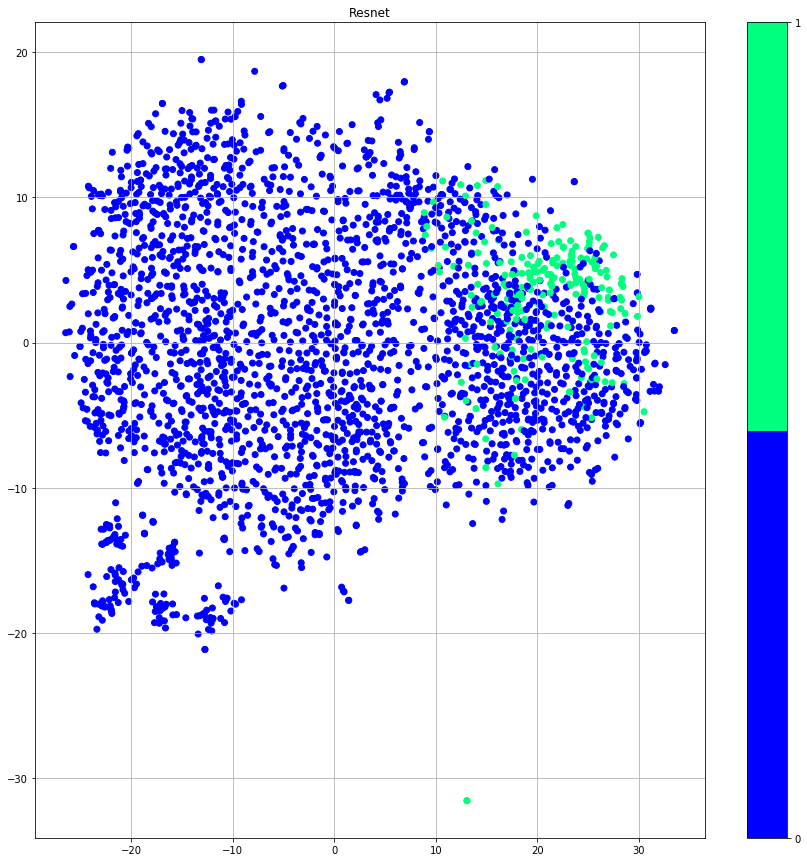

In [46]:
name = 'Resnet'
print('visualizing for %s' %name)
base_model_ = Model(input=model.input, output=model.get_layer('avg_pool').output)
tsne_feats = t_sne_vis(name, base_model_, X_valid, np.random.RandomState(42), Y_valid)

## V. Evaluate Model

In [28]:
model = load_model(weights_path+"BestKerasResnet50_flat.h5", custom_objects={'sensitivity': sensitivity,
                                                                             "specificity":specificity})
score = model.evaluate(X_valid, Y_valid, verbose=1)
print('Test loss:', score[0])
print('Test sensitivity:', score[1])
print('Test specificity:', score[2])

2758/2758 [==============================] - 18s 7ms/step
('Test loss:', 0.1355142346836567)
('Test sensitivity:', 0.49349769567388657)
('Test specificity:', 0.98025629155613359)


In [29]:
#compute metrics
pred = model.predict(X_valid)
average_precision = average_precision_score(Y_valid, pred)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.70


Text(0.5,1,u'2-class Precision-Recall curve: AP=0.70')

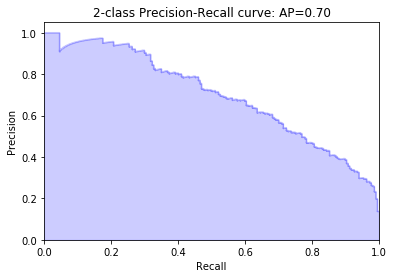

In [37]:
precision, recall, _ = precision_recall_curve(Y_valid, pred)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [39]:
def generate_results(y_test, y_score):
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.show()
    print('AUC: %f' % roc_auc)

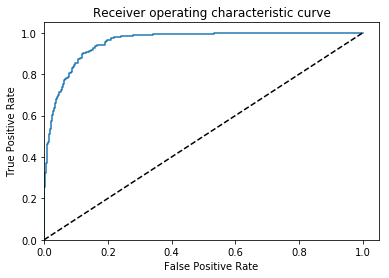

AUC: 0.955375


In [40]:
generate_results

#compute log loss
pred = model.predict(X_valid)
log_loss(Y_valid,pred)